<a href="https://colab.research.google.com/github/ashkanb77/polarity-detection/blob/main/polarity_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import zipfile
from nltk.corpus import stopwords
from nltk import word_tokenize, download
from string import punctuation

In [ ]:
zipfile.ZipFile('data.zip').extractall('')

In [3]:
download('stopwords')
download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
neg_docs = []
neg_max = 0
for file_name in os.listdir('drive/MyDrive/data/neg'):
  with open('drive/MyDrive/data/neg/' + file_name) as file:
    txt = file.read()
    tokens = word_tokenize(txt)
    trans = str.maketrans('', '', punctuation)
    tokens = [w.translate(trans) for w in tokens if not w in stop_words]
    if len(tokens) > neg_max:
      neg_max = len(tokens)
    neg_docs.append(' '.join(tokens))
len(neg_docs)

1000

In [5]:
pos_docs = []
pos_max = 0
for file_name in os.listdir('drive/MyDrive/data/pos'):
  with open('drive/MyDrive/data/pos/' + file_name) as file:
    txt = file.read()
    tokens = word_tokenize(txt)
    trans = str.maketrans('', '', punctuation)
    tokens = [w.translate(trans) for w in tokens if not w in stop_words]
    if len(tokens) > pos_max:
      pos_max = len(tokens)
    pos_docs.append(' '.join(tokens))
len(pos_docs)

1000

In [6]:
import random
random.shuffle(pos_docs)
random.shuffle(neg_docs)

In [7]:
X_train = neg_docs[:800] + pos_docs[:800]
y_train = [0 for _ in range(800)] + [1 for _ in range(800)]

In [8]:
X_test = neg_docs[800:] + pos_docs[800:]
y_test = [0 for _ in range(200)] + [1 for _ in range(200)]

In [9]:
max_len = max(pos_max, neg_max)

In [12]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPool1D, Input, Embedding, concatenate


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train + X_test)

In [12]:
with open('drive/MyDrive/data/tokenizer.h5', 'wb') as file:
  pickle.dump(tokenizer, file)

In [11]:
# tokenizer.word_index

In [13]:
with open('drive/MyDrive/data/tokenizer.h5', 'rb') as file:
  tokenizer = pickle.load(file)

In [14]:
vocab_len = len(tokenizer.word_index) + 1
vocab_len

44897

In [15]:
encoded = tokenizer.texts_to_sequences(X_train)
encoded_test = tokenizer.texts_to_sequences(X_test)

In [16]:
padded = pad_sequences(encoded, maxlen=max_len, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_len, padding='post')

In [17]:
padded.shape

(1600, 1759)

In [38]:
inp1 = Input(shape=(padded.shape[1], ))
embd1 = Embedding(vocab_len, 70)(inp1)
conv1 = Conv1D(filters=32, kernel_size=7, activation='relu')(embd1)
drop1 = Dropout(0.3)(conv1)
pool1 = MaxPool1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
dense1 = Dense(10, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(dense1)

In [39]:
model = Model(inputs=inp1, outputs=output)

In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1759)]            0         
                                                                 
 embedding_4 (Embedding)     (None, 1759, 70)          3142790   
                                                                 
 conv1d_4 (Conv1D)           (None, 1753, 32)          15712     
                                                                 
 dropout_4 (Dropout)         (None, 1753, 32)          0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 876, 32)          0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 28032)             0         
                                                           

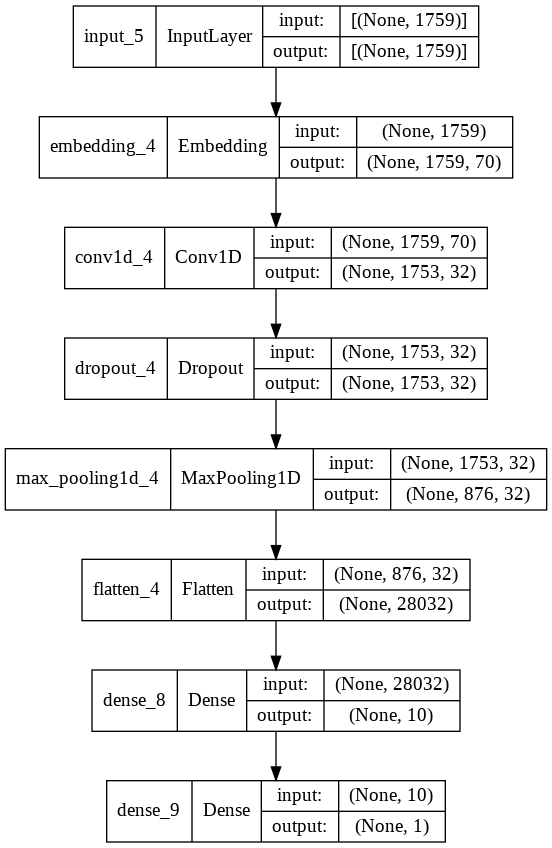

In [44]:
plot_model(model, show_shapes=True)

In [42]:
chp = ModelCheckpoint(
    'drive/MyDrive/data/polarity_model.h5', monitor='val_loss', 
    save_best_only=True, mode='min'
    )

erlstp = EarlyStopping(monitor='val_loss', patience=7, mode='min')

In [43]:
hist = model.fit(
    padded, np.array(y_train), epochs=15, batch_size=30,
    validation_data=(padded_test, np.array(y_test)),
    callbacks=[chp, erlstp]
    )

Epoch 1/15
54/54 [==============================] - 16s 274ms/step - loss: 0.6914 - accuracy: 0.5306 - val_loss: 0.6845 - val_accuracy: 0.5400
Epoch 2/15
54/54 [==============================] - 15s 276ms/step - loss: 0.6342 - accuracy: 0.6150 - val_loss: 0.6087 - val_accuracy: 0.7225
Epoch 3/15
54/54 [==============================] - 15s 277ms/step - loss: 0.4365 - accuracy: 0.8863 - val_loss: 0.5298 - val_accuracy: 0.8425
Epoch 4/15
54/54 [==============================] - 15s 273ms/step - loss: 0.3374 - accuracy: 0.9737 - val_loss: 0.4891 - val_accuracy: 0.8525
Epoch 5/15
54/54 [==============================] - 14s 259ms/step - loss: 0.3042 - accuracy: 0.9950 - val_loss: 0.5163 - val_accuracy: 0.8200
Epoch 6/15
54/54 [==============================] - 15s 274ms/step - loss: 0.2851 - accuracy: 0.9962 - val_loss: 0.4737 - val_accuracy: 0.8500
Epoch 7/15
54/54 [==============================] - 17s 306ms/step - loss: 0.2712 - accuracy: 0.9969 - val_loss: 0.4619 - val_accuracy: 0.8575